Introduction
--------
In this notebook I convert my curated CBIS-DDSM mass table into a YOLO-style object-detection dataset, visually audit the generated labels, write a minimal dataset YAML, and launch a baseline YOLOv8 training run. I keep the process deterministic and auditable so I can iterate on model capacity and augmentation later without re-engineering the data path.

Workflow
- environment setup and imports
- dataset configuration and folder scaffold for YOLO
- box synthesis from precomputed cropped ROIs via template matching
- quick visualization loop to QA labels
- dataset YAML materialization
- YOLOv8 training with explicit hyperparameters

Assumptions
- `mass_preprocessed_clean.csv.csv` contains full-image paths and cropped ROI paths that are consistent on disk
- each cropped ROI truly originates from its corresponding full image
- I treat all detections as a single class (`lesion`) for this baseline

In [1]:
# === Environment Configuration ===
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"  # allow MKL/OpenMP coexistence to avoid import warnings on some setups

# === Core Libraries ===
import os
import cv2
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path

# === Ultralytics YOLO ===
from ultralytics import YOLO  # entrypoint for training/eval/inference

# === IMPORTS ===
from pathlib import Path
import os
import cv2
import matplotlib.pyplot as plt

Configuration and directory scaffold
------------------------------------
I resolve the project root relative to the notebook, point to the source CSV with preprocessed mass samples, and define the root folder where I will build the YOLO dataset layout. I then create the canonical `images/` and `labels/` subtrees that YOLO expects.

Notes
- I place images under `images/all` and labels under `labels/all` as a single pool in this baseline
- class mapping is implicit (single class id 0 → "lesion") and encoded in the label lines later

In [2]:
# === CONFIG ===
# Go one level up from notebooks/ folder to reach project root
PROJECT_DIR = Path().resolve().parent

# Paths
csv_path = PROJECT_DIR / "data" / "mass_preprocessed_clean.csv" 
yolo_base_path = PROJECT_DIR / "data" /"CBIS_YOLO_TRAIN_DATASET"                    


# === CREATE YOLO FOLDER STRUCTURE ===
def setup_yolo_directories(base_path):
    """
    Creates the directory structure for YOLO training:
    base_path/
        └── images/
              └── all/
        └── labels/
              └── all/
    """
    images_dir = os.path.join(base_path, "images", "all")
    labels_dir = os.path.join(base_path, "labels", "all")
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)
    return images_dir, labels_dir

output_images_dir, output_labels_dir = setup_yolo_directories(yolo_base_path)



Helper functions
----------------
I synthesize bounding boxes from the provided cropped ROI images by locating each crop within its parent full image using normalized cross-correlation template matching. I then convert the pixel-space rectangle into YOLO’s relative format `(xc, yc, w, h)`.

Caveat
- template matching assumes the crop is an exact sub-image of the full image (same intensity scaling and no rotation); this is adequate for my curated crops


In [3]:
# === HELPER FUNCTIONS ===
def get_crop_bbox(full_img, crop_img):
    """
    Find where the cropped image matches the full image using template matching.
    Returns x1, y1, x2, y2 bounding box in pixel coordinates.
    """
    full_gray = cv2.cvtColor(full_img, cv2.COLOR_BGR2GRAY)
    crop_gray = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
    result = cv2.matchTemplate(full_gray, crop_gray, cv2.TM_CCOEFF_NORMED)
    _, _, _, max_loc = cv2.minMaxLoc(result)  # location of best match (top-left)
    x1, y1 = max_loc
    h, w = crop_gray.shape
    return x1, y1, x1 + w, y1 + h

def to_yolo_format(x1, y1, x2, y2, img_w, img_h):
    """
    Converts bounding box coordinates to YOLO format.
    """
    x_center = ((x1 + x2) / 2) / img_w
    y_center = ((y1 + y2) / 2) / img_h
    width = (x2 - x1) / img_w
    height = (y2 - y1) / img_h
    return x_center, y_center, width, height



Generate YOLO images and labels
-------------------------------
For each full image in the CSV I:
- copy the full image to `images/all/`
- iterate all cropped ROIs that belong to that image
- localize each crop in the full image via template matching
- append a YOLO label line `0 xc yc w h` (single-class baseline) to the corresponding `.txt` in `labels/all/`

I keep a running log of missing files or matching failures so I can trace and correct source issues quickly.


In [4]:
# === MAIN PROCESSING ===
df = pd.read_csv(csv_path)
grouped = df.groupby('image_path')

for image_path, group in tqdm(grouped, desc="Processing Full Images"):
    if not os.path.exists(image_path):
        print(f"[Warning] Full image not found: {image_path}")
        continue

    full_img = cv2.imread(image_path)
    if full_img is None:
        print(f"[Error] Failed to read full image: {image_path}")
        continue

    img_h, img_w = full_img.shape[:2]
    image_filename = os.path.basename(image_path)
    label_filename = os.path.splitext(image_filename)[0] + ".txt"

    # Save full image to YOLO image directory
    output_img_path = os.path.join(output_images_dir, image_filename)
    cv2.imwrite(output_img_path, full_img)

    annotations = []

    for _, row in group.iterrows():
        cropped_path = row["cropped_image_path"]

        if not os.path.exists(cropped_path):
            print(f"[Warning] Cropped image not found: {cropped_path}")
            continue

        cropped_img = cv2.imread(cropped_path)
        if cropped_img is None:
            print(f"[Error] Failed to read cropped image: {cropped_path}")
            continue

        try:
            x1, y1, x2, y2 = get_crop_bbox(full_img, cropped_img)
            x_center, y_center, w, h = to_yolo_format(x1, y1, x2, y2, img_w, img_h)
            annotations.append(f"0 {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}")
        except Exception as e:
            print(f"[Error] Failed to match crop for {cropped_path}: {e}")

    if annotations:
        label_path = os.path.join(output_labels_dir, label_filename)
        with open(label_path, 'w') as f:
            f.write("\n".join(annotations))

Processing Full Images: 100%|██████████| 1592/1592 [11:13<00:00,  2.37it/s]


Label visualization (QA)
------------------------
I render each image with its YOLO boxes to visually verify that the synthesized annotations actually sit on the lesions. The loop pauses per image so I can skim quickly and quit with `q` if needed.

What I look for
- boxes tightly covering the ROI
- no wild off-image coordinates (clamped in code)
- reasonable behavior when multiple crops map to the same full image

Images dir exists: True
Labels dir exists: True


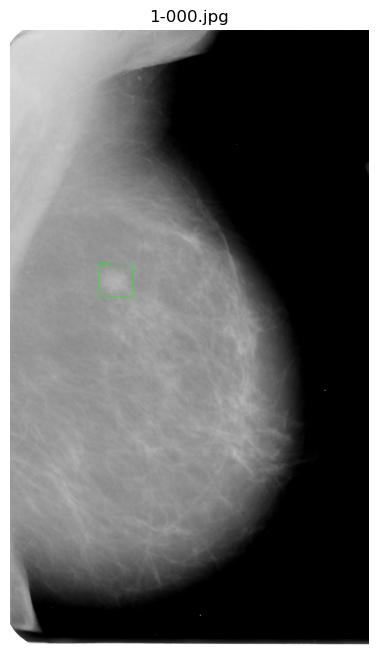

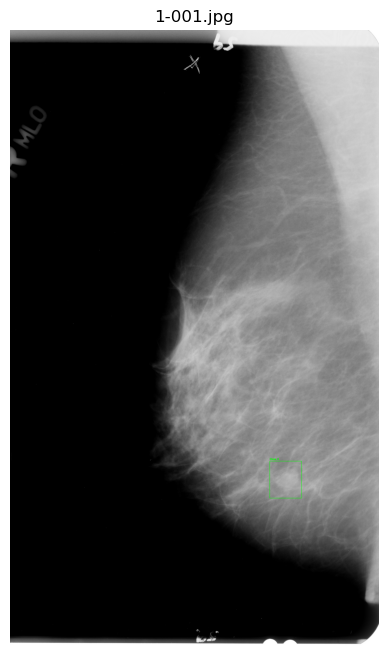

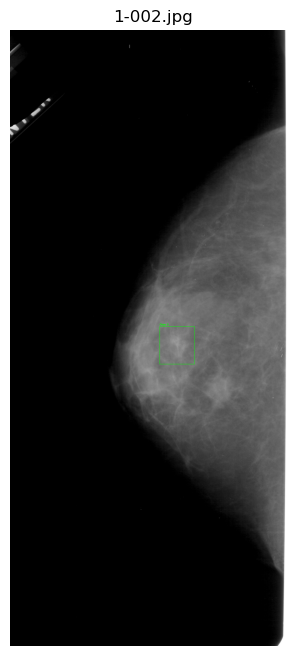

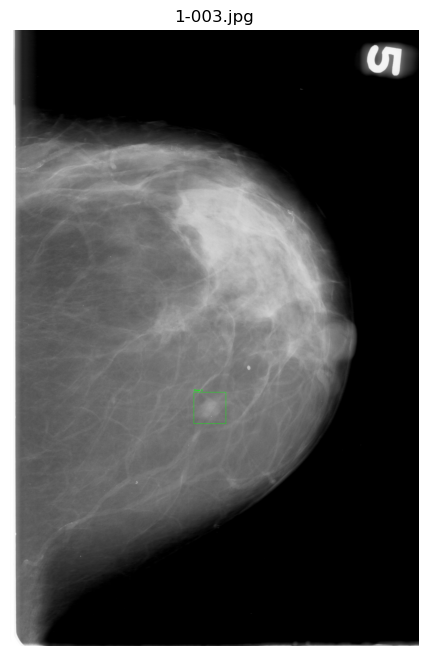

In [5]:
# === CONFIG ===
PROJECT_DIR = Path().resolve().parent

dataset_dir = PROJECT_DIR / "data" / "CBIS_YOLO_TRAIN_DATASET"
images_dir  = dataset_dir / "images" / "all"
labels_dir  = dataset_dir / "labels" / "all"

print("Images dir exists:", images_dir.exists())
print("Labels dir exists:", labels_dir.exists())

# === VISUALIZATION FUNCTION ===
def draw_yolo_bboxes(image_path: Path, label_path: Path):
    """Draw YOLO-format boxes (class xc yc w h in relative coords) on an image."""
    # OpenCV needs a string path
    image = cv2.imread(str(image_path))
    if image is None:
        print(f"[Error] Could not read image: {image_path}")
        return

    img_h, img_w = image.shape[:2]

    if not label_path.exists():
        print(f"[Warning] No label file for: {image_path.name}")
    else:
        try:
            with open(label_path, "r", encoding="utf-8") as f:
                lines = [ln.strip() for ln in f if ln.strip()]
        except Exception as e:
            print(f"[Warning] Failed to read label file {label_path}: {e}")
            lines = []

        for line in lines:
            parts = line.split()
            if len(parts) != 5:
                print(f"[Warning] Skipping invalid line in {label_path.name}: {line}")
                continue

            try:
                cls_id, x_center, y_center, width, height = map(float, parts)
            except ValueError:
                print(f"[Warning] Non-numeric values in {label_path.name}: {line}")
                continue

            # Convert YOLO (relative) -> pixel coords
            x_center *= img_w
            y_center *= img_h
            width    *= img_w
            height   *= img_h

            x1 = int(x_center - width  / 2)
            y1 = int(y_center - height / 2)
            x2 = int(x_center + width  / 2)
            y2 = int(y_center + height / 2)

            # Clamp to image bounds
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(img_w - 1, x2), min(img_h - 1, y2)

            # Draw
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(image, f"Class {int(cls_id)}", (x1, max(0, y1 - 10)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Show with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 8))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title(image_path.name)
    plt.show()

# === LOOP OVER IMAGES ===
# Accept common extensions
exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}
image_files = sorted([p for p in images_dir.iterdir() if p.suffix.lower() in exts],
                     key=lambda p: p.name.lower())

if not image_files:
    print("[Info] No images found. Check images_dir path or file extensions.")

for img_path in image_files:
    lbl_path = labels_dir / (img_path.stem + ".txt")
    draw_yolo_bboxes(img_path, lbl_path)

    user_input = input("Press Enter for next image, or 'q' to quit: ").strip().lower()
    if user_input == 'q':
        break

Dataset YAML
------------
I write a minimal YOLO dataset configuration that points to the dataset root and declares a single class. For this baseline I reference the same `images` directory for both train and val. In later experiments I will split into explicit `images/train` and `images/val` subfolders and update the YAML accordingly.


In [6]:
yaml_path = PROJECT_DIR / "data" / "cbis.yaml"

# sanity checks (optional)
print("images dir exists:", (dataset_dir / "images").exists())
print("labels dir exists:", (dataset_dir / "labels").exists())

yaml_content = f"""\
# YOLO dataset config
path: {dataset_dir.as_posix()}   # absolute path to dataset root
train: images                    # (relative to 'path')
val: images                      # you can point to a separate val folder later

nc: 1
names: ['lesion']
"""

yaml_path.write_text(yaml_content, encoding="utf-8")
print("Wrote:", yaml_path)
print(yaml_content)


images dir exists: True
labels dir exists: True
Wrote: C:\Users\PC\Desktop\final project\CBIS-DDSM\mass\YOLO model\data\cbis.yaml
# YOLO dataset config
path: C:/Users/PC/Desktop/final project/CBIS-DDSM/mass/YOLO model/data/CBIS_YOLO_TRAIN_DATASET   # absolute path to dataset root
train: images                    # (relative to 'path')
val: images                      # you can point to a separate val folder later

nc: 1
names: ['lesion']



Train a baseline YOLOv8 model
-----------------------------
I set a few explicit training hyperparameters and launch finetuning from the `yolov8s.pt` checkpoint. I keep the configuration readable and reproducible:
- epochs, image size, batch size, optimizer and learning rate
- early stopping patience and warmup
- output project/name and a fixed seed for determinism

The goal here is to establish a traceable baseline before exploring capacity, augmentation, or loss variations.

In [7]:
# Prevent memory fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

model = YOLO("yolov8s.pt")  # Lightweight model with good performance

model.train(
    data=str(yaml_path),
    epochs=150,
    imgsz=800,
    batch=4,
    device=0,
    lr0=0.001,
    optimizer="SGD",
    patience=20,
    workers=4,
    project=str(PROJECT_DIR / "CBIS_YOLO_PROJECT_output"),
    name="yolov8s_optimized",
    verbose=True,
    pretrained=True,
    close_mosaic=10,
    warmup_epochs=5,
    dropout=0.2,
    seed=42,
)

100%|██████████| 21.5M/21.5M [00:06<00:00, 3.47MB/s]


New https://pypi.org/project/ultralytics/8.3.202 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.171  Python-3.13.5 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\PC\Desktop\final project\CBIS-DDSM\mass\YOLO model\data\cbis.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.2, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=800, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, n

c:\Users\PC\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1341: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(
100%|██████████| 5.35M/5.35M [00:01<00:00, 3.49MB/s]


AMP: checks passed 
train: Fast image access  (ping: 0.00.0 ms, read: 217.189.5 MB/s, size: 1619.8 KB)


train: Scanning C:\Users\PC\Desktop\final project\CBIS-DDSM\mass\YOLO model\data\CBIS_YOLO_TRAIN_DATASET\labels\all... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<00:00, 541.13it/s]

train: New cache created: C:\Users\PC\Desktop\final project\CBIS-DDSM\mass\YOLO model\data\CBIS_YOLO_TRAIN_DATASET\labels\all.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.00.0 ms, read: 1133.8103.4 MB/s, size: 1583.3 KB)


val: Scanning C:\Users\PC\Desktop\final project\CBIS-DDSM\mass\YOLO model\data\CBIS_YOLO_TRAIN_DATASET\labels\all.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]


Plotting labels to C:\Users\PC\Desktop\final project\CBIS-DDSM\mass\YOLO model\CBIS_YOLO_PROJECT_output\yolov8s_optimized\labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 800 train, 800 val
Using 4 dataloader workers
Logging results to C:\Users\PC\Desktop\final project\CBIS-DDSM\mass\YOLO model\CBIS_YOLO_PROJECT_output\yolov8s_optimized
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150       1.5G      3.088      24.56      2.327          8        800: 100%|██████████| 75/75 [00:08<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00,  9.66it/s]

                   all        300        321     0.0032    0.00623   0.000539   0.000189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.66G      2.759      5.875      2.219          8        800: 100%|██████████| 75/75 [00:07<00:00, 10.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 11.95it/s]


                   all        300        321     0.0197    0.00623    0.00642    0.00147

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.66G      2.543      4.081      2.113          5        800: 100%|██████████| 75/75 [00:07<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 11.86it/s]


                   all        300        321      0.224      0.125     0.0688     0.0274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.68G      2.364      3.337       2.03          7        800: 100%|██████████| 75/75 [00:07<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 11.69it/s]


                   all        300        321      0.233      0.112     0.0803      0.029

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      1.68G      2.325      3.031      2.006          9        800: 100%|██████████| 75/75 [00:07<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.02it/s]


                   all        300        321      0.376      0.212      0.184     0.0694

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.68G       2.27       2.89      1.932         11        800: 100%|██████████| 75/75 [00:07<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 11.45it/s]


                   all        300        321      0.369      0.325      0.276      0.101

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.68G      2.122      2.577      1.892          6        800: 100%|██████████| 75/75 [00:07<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.16it/s]


                   all        300        321      0.384      0.262      0.245      0.102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.68G      2.124      2.495      1.787          9        800: 100%|██████████| 75/75 [00:07<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.15it/s]


                   all        300        321      0.364      0.299      0.251      0.107

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      1.68G       2.15      2.346      1.782          5        800: 100%|██████████| 75/75 [00:07<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.13it/s]

                   all        300        321      0.518      0.371       0.37      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      1.68G      2.033      2.311      1.717         10        800: 100%|██████████| 75/75 [00:07<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 11.72it/s]

                   all        300        321      0.445      0.414      0.382      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.69G      2.028      2.152      1.668          3        800: 100%|██████████| 75/75 [00:07<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.28it/s]

                   all        300        321      0.497      0.318      0.329      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.71G      2.021      2.237      1.697          5        800: 100%|██████████| 75/75 [00:07<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.17it/s]

                   all        300        321      0.455      0.442      0.378       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.73G       2.03      2.216      1.635          9        800: 100%|██████████| 75/75 [00:07<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.24it/s]

                   all        300        321       0.48      0.408      0.374      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.73G      1.924       2.23      1.591          7        800: 100%|██████████| 75/75 [00:07<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.15it/s]

                   all        300        321      0.519      0.424      0.428       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.73G      1.933       2.07      1.635         11        800: 100%|██████████| 75/75 [00:07<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 11.89it/s]

                   all        300        321      0.546      0.414      0.407      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.73G      1.838       2.01      1.556          6        800: 100%|██████████| 75/75 [00:07<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.26it/s]

                   all        300        321      0.538      0.467      0.456      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.73G       1.81      1.981      1.526          5        800: 100%|██████████| 75/75 [00:07<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.32it/s]

                   all        300        321      0.537      0.509      0.488      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.73G      1.841      2.026      1.556         10        800: 100%|██████████| 75/75 [00:07<00:00, 10.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.02it/s]

                   all        300        321      0.551      0.477      0.478      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      1.73G      1.882      1.856      1.545         14        800: 100%|██████████| 75/75 [00:07<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.15it/s]

                   all        300        321      0.509       0.48      0.442      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      1.73G      1.868      1.965      1.516          4        800: 100%|██████████| 75/75 [00:07<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.02it/s]

                   all        300        321      0.597      0.498      0.496      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      1.73G      1.771      1.786      1.479          6        800: 100%|██████████| 75/75 [00:07<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.25it/s]

                   all        300        321      0.664      0.477      0.527      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      1.73G      1.817      1.819      1.452          7        800: 100%|██████████| 75/75 [00:07<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.25it/s]

                   all        300        321      0.647      0.498      0.537       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      1.73G      1.741      1.746      1.426         10        800: 100%|██████████| 75/75 [00:07<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.04it/s]

                   all        300        321      0.627      0.502       0.55      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      1.73G      1.841      1.816      1.469          9        800: 100%|██████████| 75/75 [00:07<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.29it/s]

                   all        300        321      0.618      0.536      0.586       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      1.73G      1.776      1.747      1.453          9        800: 100%|██████████| 75/75 [00:07<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 11.96it/s]


                   all        300        321      0.701      0.523      0.594      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      1.73G      1.758       1.79      1.457          9        800: 100%|██████████| 75/75 [00:07<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.12it/s]

                   all        300        321      0.593       0.53      0.582       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      1.73G       1.69      1.659      1.411         13        800: 100%|██████████| 75/75 [00:07<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.03it/s]

                   all        300        321      0.662      0.607       0.66      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      1.76G      1.711      1.702       1.41          4        800: 100%|██████████| 75/75 [00:07<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.22it/s]

                   all        300        321      0.681      0.598      0.659      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      1.76G      1.733      1.674      1.433         10        800: 100%|██████████| 75/75 [00:07<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.20it/s]

                   all        300        321      0.706      0.627      0.703      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      1.76G      1.774      1.633      1.433         18        800: 100%|██████████| 75/75 [00:07<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.36it/s]

                   all        300        321      0.664      0.629      0.683       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      1.76G      1.678      1.589      1.366          8        800: 100%|██████████| 75/75 [00:07<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.19it/s]

                   all        300        321      0.692      0.679       0.74      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      1.76G      1.649      1.628       1.36         15        800: 100%|██████████| 75/75 [00:07<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 11.91it/s]

                   all        300        321      0.717      0.632      0.692      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.76G      1.748      1.571      1.445          6        800: 100%|██████████| 75/75 [00:07<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 11.89it/s]

                   all        300        321      0.744      0.624       0.71       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.76G      1.713      1.582       1.46         10        800: 100%|██████████| 75/75 [00:07<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.16it/s]

                   all        300        321      0.789      0.619      0.738      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      1.76G      1.668      1.492       1.39         11        800: 100%|██████████| 75/75 [00:07<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.27it/s]

                   all        300        321      0.669      0.662      0.734      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      1.76G      1.607      1.454      1.352          7        800: 100%|██████████| 75/75 [00:07<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.29it/s]

                   all        300        321      0.762      0.709      0.792      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      1.76G      1.704      1.432      1.415          9        800: 100%|██████████| 75/75 [00:07<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.47it/s]

                   all        300        321      0.806      0.692      0.794      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      1.76G      1.686      1.446      1.392          7        800: 100%|██████████| 75/75 [00:07<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.31it/s]

                   all        300        321      0.739       0.66      0.752      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      1.76G      1.654      1.375      1.355         10        800: 100%|██████████| 75/75 [00:07<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 11.63it/s]

                   all        300        321      0.679      0.757      0.784      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      1.76G      1.629      1.379      1.355          6        800: 100%|██████████| 75/75 [00:07<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.08it/s]

                   all        300        321      0.742      0.733      0.798      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      1.78G       1.64      1.428      1.328         10        800: 100%|██████████| 75/75 [00:07<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.08it/s]

                   all        300        321      0.838       0.72      0.822      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      1.78G      1.576      1.332      1.339          5        800: 100%|██████████| 75/75 [00:07<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.20it/s]

                   all        300        321      0.783      0.785      0.827      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      1.78G      1.594      1.325      1.326          6        800: 100%|██████████| 75/75 [00:07<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.31it/s]

                   all        300        321      0.868      0.739      0.855      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      1.78G      1.537      1.259      1.258         11        800: 100%|██████████| 75/75 [00:07<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 11.99it/s]

                   all        300        321      0.865       0.78      0.864      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      1.78G      1.633       1.27      1.345          4        800: 100%|██████████| 75/75 [00:07<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.16it/s]

                   all        300        321      0.806      0.777       0.86      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      1.78G      1.537      1.246      1.275         10        800: 100%|██████████| 75/75 [00:07<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.16it/s]

                   all        300        321      0.837      0.645       0.79      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      1.78G      1.545      1.207      1.286          5        800: 100%|██████████| 75/75 [00:07<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.16it/s]

                   all        300        321      0.806      0.789      0.861      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      1.78G      1.633      1.265      1.344          8        800: 100%|██████████| 75/75 [00:07<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.43it/s]

                   all        300        321      0.794      0.637       0.76      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      1.78G      1.505      1.227      1.278          7        800: 100%|██████████| 75/75 [00:07<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.42it/s]

                   all        300        321      0.782      0.783       0.84      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      1.78G      1.583      1.222      1.308          9        800: 100%|██████████| 75/75 [00:07<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.14it/s]

                   all        300        321       0.86      0.744      0.864      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      1.78G      1.471      1.152      1.252          6        800: 100%|██████████| 75/75 [00:07<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.11it/s]

                   all        300        321      0.895      0.824      0.911      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      1.78G      1.465      1.138      1.269         10        800: 100%|██████████| 75/75 [00:07<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.21it/s]

                   all        300        321      0.893       0.81      0.907      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      1.78G       1.49      1.145      1.258          7        800: 100%|██████████| 75/75 [00:07<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.26it/s]

                   all        300        321      0.865       0.82      0.903       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      1.78G      1.493      1.133      1.275         13        800: 100%|██████████| 75/75 [00:07<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.17it/s]

                   all        300        321      0.884       0.86       0.93      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      1.78G      1.422      1.066      1.216          6        800: 100%|██████████| 75/75 [00:07<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.33it/s]

                   all        300        321      0.849      0.857      0.918      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      1.78G      1.455      1.086      1.246          9        800: 100%|██████████| 75/75 [00:07<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.08it/s]

                   all        300        321      0.866      0.879      0.938      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      1.78G      1.472      1.047      1.242          4        800: 100%|██████████| 75/75 [00:07<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.41it/s]

                   all        300        321      0.848      0.885      0.932      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      1.78G      1.446      1.055      1.232          7        800: 100%|██████████| 75/75 [00:07<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 11.81it/s]

                   all        300        321       0.91      0.908      0.957       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      1.78G      1.441      1.071      1.215         10        800: 100%|██████████| 75/75 [00:07<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.13it/s]

                   all        300        321      0.874      0.875      0.941      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      1.78G      1.433      1.029      1.227          5        800: 100%|██████████| 75/75 [00:07<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.34it/s]

                   all        300        321      0.902       0.86       0.94      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      1.78G        1.4      1.027      1.204         13        800: 100%|██████████| 75/75 [00:07<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.47it/s]

                   all        300        321       0.86      0.899       0.94      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      1.78G      1.392      1.045      1.214         10        800: 100%|██████████| 75/75 [00:07<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.26it/s]

                   all        300        321      0.898      0.874      0.945      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      1.78G       1.34     0.9344      1.156          4        800: 100%|██████████| 75/75 [00:07<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.17it/s]

                   all        300        321      0.887      0.891      0.949      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      1.78G      1.374      0.953      1.203          7        800: 100%|██████████| 75/75 [00:07<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.49it/s]

                   all        300        321      0.913      0.872      0.952      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      1.78G      1.371     0.9568      1.176         10        800: 100%|██████████| 75/75 [00:07<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.24it/s]

                   all        300        321      0.913      0.894      0.964      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      1.78G       1.39       1.03       1.22          7        800: 100%|██████████| 75/75 [00:07<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 11.71it/s]

                   all        300        321      0.924      0.928      0.971      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      1.78G       1.33      1.013      1.186          9        800: 100%|██████████| 75/75 [00:07<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.24it/s]

                   all        300        321      0.936      0.911       0.97      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      1.78G      1.372     0.9574      1.185          7        800: 100%|██████████| 75/75 [00:07<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.46it/s]

                   all        300        321      0.909      0.901      0.958      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      1.78G      1.319     0.9595      1.163          7        800: 100%|██████████| 75/75 [00:07<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.25it/s]

                   all        300        321      0.877      0.885      0.938      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      1.78G      1.312      0.889      1.183          8        800: 100%|██████████| 75/75 [00:07<00:00, 10.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.45it/s]

                   all        300        321      0.879      0.829      0.925      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      1.78G      1.317     0.9049      1.171          6        800: 100%|██████████| 75/75 [00:07<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.23it/s]

                   all        300        321      0.881      0.944      0.969      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      1.78G      1.331     0.8842      1.136          8        800: 100%|██████████| 75/75 [00:07<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.26it/s]

                   all        300        321       0.92      0.926      0.973      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      1.78G      1.378     0.9694      1.168         10        800: 100%|██████████| 75/75 [00:07<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.29it/s]

                   all        300        321      0.935      0.937      0.978      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      1.78G       1.26     0.8742       1.12         10        800: 100%|██████████| 75/75 [00:07<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.15it/s]

                   all        300        321      0.934      0.931      0.975      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      1.79G      1.316     0.8916      1.136          5        800: 100%|██████████| 75/75 [00:07<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.26it/s]

                   all        300        321      0.902      0.919      0.956      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150       1.8G       1.31     0.9188      1.144         10        800: 100%|██████████| 75/75 [00:07<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.31it/s]

                   all        300        321      0.922      0.935      0.973       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      1.83G      1.287      0.915      1.122          5        800: 100%|██████████| 75/75 [00:07<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.24it/s]

                   all        300        321      0.926      0.947      0.978      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      1.83G      1.253     0.8591      1.125          5        800: 100%|██████████| 75/75 [00:07<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.19it/s]

                   all        300        321      0.938      0.945       0.98      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      1.83G      1.296     0.9075      1.148         10        800: 100%|██████████| 75/75 [00:07<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 11.95it/s]

                   all        300        321      0.905      0.892      0.967      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      1.83G      1.232     0.8478      1.117          7        800: 100%|██████████| 75/75 [00:07<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 11.98it/s]

                   all        300        321      0.917       0.95      0.977      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      1.83G      1.249     0.8024      1.126         12        800: 100%|██████████| 75/75 [00:07<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.30it/s]

                   all        300        321      0.872      0.916      0.956       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      1.83G      1.239     0.8422      1.105          8        800: 100%|██████████| 75/75 [00:07<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.37it/s]

                   all        300        321      0.953      0.953      0.984      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      1.83G      1.242     0.7996      1.121          4        800: 100%|██████████| 75/75 [00:07<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.28it/s]

                   all        300        321      0.903      0.894      0.962      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      1.83G      1.273     0.8077      1.143          8        800: 100%|██████████| 75/75 [00:07<00:00, 10.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.23it/s]

                   all        300        321      0.935      0.947      0.981      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      1.83G      1.194     0.8215      1.111          5        800: 100%|██████████| 75/75 [00:07<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.34it/s]

                   all        300        321      0.917      0.969      0.985      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150       1.9G      1.281      0.864      1.131          9        800: 100%|██████████| 75/75 [00:07<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.05it/s]

                   all        300        321      0.951      0.959      0.988      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150       1.9G      1.197     0.8164      1.096          5        800: 100%|██████████| 75/75 [00:07<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.21it/s]

                   all        300        321      0.934      0.944      0.983       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150       1.9G      1.204     0.7661      1.077          8        800: 100%|██████████| 75/75 [00:07<00:00, 10.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.63it/s]

                   all        300        321      0.945      0.963      0.989       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150       1.9G      1.212     0.7847      1.092          7        800: 100%|██████████| 75/75 [00:07<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.18it/s]

                   all        300        321      0.956      0.966      0.988      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150       1.9G      1.174     0.7656      1.086          3        800: 100%|██████████| 75/75 [00:07<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.12it/s]

                   all        300        321      0.948      0.971       0.99      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150       1.9G      1.214     0.7921      1.104          6        800: 100%|██████████| 75/75 [00:07<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.18it/s]

                   all        300        321      0.948      0.966       0.99      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      1.92G      1.204     0.7944      1.111          7        800: 100%|██████████| 75/75 [00:07<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.50it/s]

                   all        300        321      0.969      0.913      0.985      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      1.92G      1.221     0.7696      1.084          7        800: 100%|██████████| 75/75 [00:07<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.11it/s]

                   all        300        321      0.944      0.969      0.989      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      1.92G       1.16     0.7915      1.074          9        800: 100%|██████████| 75/75 [00:07<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.10it/s]

                   all        300        321      0.906      0.901      0.972      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      1.92G      1.177     0.7671      1.089          6        800: 100%|██████████| 75/75 [00:07<00:00, 10.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 11.95it/s]

                   all        300        321      0.954      0.947      0.983      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      1.92G      1.217     0.8053      1.105          6        800: 100%|██████████| 75/75 [00:07<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.39it/s]

                   all        300        321      0.947      0.966      0.988      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      1.92G      1.163     0.7581       1.07          6        800: 100%|██████████| 75/75 [00:07<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.46it/s]

                   all        300        321      0.948      0.974       0.99      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      1.92G      1.143     0.7396      1.054          8        800: 100%|██████████| 75/75 [00:07<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 11.94it/s]

                   all        300        321      0.937      0.984      0.991      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      1.92G      1.126     0.7399       1.07         11        800: 100%|██████████| 75/75 [00:07<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.20it/s]

                   all        300        321       0.94      0.983       0.99      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      1.92G      1.106     0.6861      1.049         10        800: 100%|██████████| 75/75 [00:07<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.15it/s]

                   all        300        321      0.951      0.965      0.988      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      1.92G      1.163     0.7449      1.069          5        800: 100%|██████████| 75/75 [00:07<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 11.92it/s]

                   all        300        321      0.963      0.956      0.991      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      1.92G      1.096     0.7081      1.044          5        800: 100%|██████████| 75/75 [00:07<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.20it/s]

                   all        300        321      0.965      0.969      0.992      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      1.92G      1.159     0.7709      1.069         11        800: 100%|██████████| 75/75 [00:07<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.34it/s]

                   all        300        321      0.955       0.98      0.992      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      1.92G      1.128     0.7417      1.053         10        800: 100%|██████████| 75/75 [00:07<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 11.98it/s]

                   all        300        321      0.963      0.974      0.992      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      1.95G       1.11     0.7577      1.041          7        800: 100%|██████████| 75/75 [00:07<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.13it/s]

                   all        300        321      0.951      0.973       0.99      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      1.95G      1.132      0.749       1.06          5        800: 100%|██████████| 75/75 [00:07<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.31it/s]

                   all        300        321      0.949      0.963      0.989      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      1.95G      1.144     0.7566      1.065         10        800: 100%|██████████| 75/75 [00:07<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.18it/s]

                   all        300        321      0.954      0.975      0.991      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      1.95G      1.102     0.7161      1.067          6        800: 100%|██████████| 75/75 [00:07<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.42it/s]

                   all        300        321      0.966      0.984      0.993      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      1.95G      1.132     0.7191      1.061          6        800: 100%|██████████| 75/75 [00:07<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.38it/s]

                   all        300        321      0.963      0.983      0.993      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      1.95G      1.119     0.6888      1.063          6        800: 100%|██████████| 75/75 [00:07<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.24it/s]

                   all        300        321      0.966      0.988      0.993      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      1.95G      1.124     0.7326      1.076          5        800: 100%|██████████| 75/75 [00:07<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.32it/s]

                   all        300        321      0.965      0.963      0.992      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      1.95G      1.058     0.6682      1.025          5        800: 100%|██████████| 75/75 [00:07<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.30it/s]

                   all        300        321      0.963      0.972      0.993      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      1.95G      1.095     0.6914      1.035         12        800: 100%|██████████| 75/75 [00:07<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 11.95it/s]

                   all        300        321      0.987      0.949      0.993      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      1.95G      1.068      0.681      1.021          4        800: 100%|██████████| 75/75 [00:07<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.07it/s]

                   all        300        321      0.995      0.966      0.994      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      1.95G      1.111     0.7501      1.048         11        800: 100%|██████████| 75/75 [00:07<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.30it/s]

                   all        300        321      0.983      0.966      0.994      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      1.95G      1.102     0.6814      1.043          5        800: 100%|██████████| 75/75 [00:07<00:00, 10.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.49it/s]

                   all        300        321       0.99       0.97      0.994       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      1.95G      1.087     0.6869       1.04          5        800: 100%|██████████| 75/75 [00:07<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.21it/s]

                   all        300        321      0.972      0.981      0.994      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      1.97G      1.093     0.7361      1.059         10        800: 100%|██████████| 75/75 [00:07<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.15it/s]

                   all        300        321      0.976      0.966      0.992      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      1.97G       1.09      0.684      1.031          9        800: 100%|██████████| 75/75 [00:07<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.26it/s]

                   all        300        321      0.969      0.973      0.993      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      1.97G      1.057     0.6691      1.023          9        800: 100%|██████████| 75/75 [00:07<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.15it/s]

                   all        300        321      0.966      0.969      0.992      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      1.97G      1.047     0.6868      1.021          7        800: 100%|██████████| 75/75 [00:07<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.24it/s]

                   all        300        321      0.981      0.965      0.993      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      1.97G      1.018     0.6591      1.005          7        800: 100%|██████████| 75/75 [00:07<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.29it/s]

                   all        300        321      0.977      0.975      0.994      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      1.97G      1.024     0.6644          1         11        800: 100%|██████████| 75/75 [00:07<00:00, 10.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.03it/s]

                   all        300        321      0.972      0.976      0.993      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      1.97G      1.021      0.657     0.9949         14        800: 100%|██████████| 75/75 [00:07<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.42it/s]

                   all        300        321      0.975       0.97      0.993      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      1.97G      1.036     0.6429      1.025          5        800: 100%|██████████| 75/75 [00:07<00:00, 10.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.41it/s]

                   all        300        321      0.984      0.977      0.994      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      1.97G       1.02      0.651      1.018          7        800: 100%|██████████| 75/75 [00:07<00:00, 10.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.51it/s]

                   all        300        321      0.975      0.984      0.994      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      1.97G      1.023     0.6418      1.021         10        800: 100%|██████████| 75/75 [00:07<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.24it/s]

                   all        300        321      0.972      0.968      0.993       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      1.97G      1.054     0.6559      1.027          6        800: 100%|██████████| 75/75 [00:07<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.52it/s]

                   all        300        321      0.992      0.966      0.994      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      1.97G      1.016     0.6514      1.011          4        800: 100%|██████████| 75/75 [00:07<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:02<00:00, 12.67it/s]

                   all        300        321      0.987      0.975      0.994       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      1.97G      1.028      0.654      1.007          6        800: 100%|██████████| 75/75 [00:07<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:02<00:00, 12.68it/s]

                   all        300        321      0.987      0.984      0.994      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      1.97G      1.017     0.6755      1.008         10        800: 100%|██████████| 75/75 [00:07<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.43it/s]

                   all        300        321      0.983      0.975      0.994      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      1.97G      1.016     0.6317     0.9963          7        800: 100%|██████████| 75/75 [00:07<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.57it/s]

                   all        300        321      0.981      0.977      0.993      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      1.97G      1.024     0.6398      1.007         10        800: 100%|██████████| 75/75 [00:07<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.61it/s]

                   all        300        321      0.984      0.978      0.994      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      1.97G      1.033     0.6779      1.021          8        800: 100%|██████████| 75/75 [00:07<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.30it/s]

                   all        300        321      0.987      0.978      0.994      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      1.97G      1.006     0.6298     0.9989          7        800: 100%|██████████| 75/75 [00:07<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.48it/s]

                   all        300        321      0.978      0.981      0.994      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      1.97G      1.027     0.6365      1.006          5        800: 100%|██████████| 75/75 [00:07<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.66it/s]

                   all        300        321      0.972      0.988      0.994      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      1.97G     0.9862     0.6295     0.9882          5        800: 100%|██████████| 75/75 [00:07<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.64it/s]

                   all        300        321      0.974      0.988      0.994      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      1.97G      1.016     0.6457      1.013          5        800: 100%|██████████| 75/75 [00:07<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.46it/s]

                   all        300        321      0.978      0.984      0.994      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      1.97G      1.009     0.6308     0.9856          6        800: 100%|██████████| 75/75 [00:07<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.34it/s]

                   all        300        321       0.97      0.984      0.994        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      1.97G      1.014     0.6125     0.9921          6        800: 100%|██████████| 75/75 [00:07<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:02<00:00, 12.71it/s]

                   all        300        321      0.978      0.971      0.994      0.804


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      1.97G       1.09     0.6443      1.031          4        800: 100%|██████████| 75/75 [00:07<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:02<00:00, 12.76it/s]

                   all        300        321       0.96      0.953      0.987      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      1.97G      1.101     0.6537      1.032          4        800: 100%|██████████| 75/75 [00:07<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.56it/s]

                   all        300        321      0.966      0.938      0.985      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      1.97G      1.073     0.6093      1.025          4        800: 100%|██████████| 75/75 [00:07<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.62it/s]

                   all        300        321      0.983      0.928      0.987      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      1.97G      1.104     0.6554      1.048          4        800: 100%|██████████| 75/75 [00:07<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.57it/s]

                   all        300        321      0.959      0.957      0.987      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      1.97G     0.9892      0.614     0.9975          4        800: 100%|██████████| 75/75 [00:07<00:00, 10.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.65it/s]

                   all        300        321      0.984      0.947      0.989      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      1.97G      1.006     0.5714     0.9956          4        800: 100%|██████████| 75/75 [00:07<00:00, 10.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.59it/s]

                   all        300        321      0.978      0.953       0.99      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      1.97G     0.9928      0.591     0.9898          4        800: 100%|██████████| 75/75 [00:07<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.10it/s]

                   all        300        321      0.983      0.956       0.99      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      1.97G     0.9873     0.5735     0.9855          4        800: 100%|██████████| 75/75 [00:07<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.58it/s]

                   all        300        321      0.984      0.952       0.99      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      1.97G     0.9426     0.5518     0.9784          4        800: 100%|██████████| 75/75 [00:07<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.57it/s]

                   all        300        321      0.984      0.956       0.99       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      1.97G     0.9894     0.6136     0.9897          4        800: 100%|██████████| 75/75 [00:07<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.44it/s]

                   all        300        321      0.962      0.955       0.99      0.781



150 epochs completed in 0.464 hours.
Optimizer stripped from C:\Users\PC\Desktop\final project\CBIS-DDSM\mass\YOLO model\CBIS_YOLO_PROJECT_output\yolov8s_optimized\weights\last.pt, 22.5MB
Optimizer stripped from C:\Users\PC\Desktop\final project\CBIS-DDSM\mass\YOLO model\CBIS_YOLO_PROJECT_output\yolov8s_optimized\weights\best.pt, 22.5MB

Validating C:\Users\PC\Desktop\final project\CBIS-DDSM\mass\YOLO model\CBIS_YOLO_PROJECT_output\yolov8s_optimized\weights\best.pt...
Ultralytics 8.3.171  Python-3.13.5 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:02<00:00, 13.55it/s]


                   all        300        321      0.987       0.98      0.994      0.805
Speed: 0.3ms preprocess, 3.0ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to C:\Users\PC\Desktop\final project\CBIS-DDSM\mass\YOLO model\CBIS_YOLO_PROJECT_output\yolov8s_optimized


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001348B7D1B00>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480